## Рекуррентные сети

Для рекуррентных сетей используем датасет с именами и будем определять из какого языка произошло данное имя. Для этого построим рекуррентную сеть, которая с именами на уровне символов. Для начала скачаем файлы и конвертируем их к удобному формату (можно не особо вникать в этот код).

In [ ]:
# На Windows придется скачать архив по ссылке (~3Mb) и распаковать самостоятельно
#! wget -nc https://download.pytorch.org/tutorial/data.zip
#! unzip -n ./data.zip

In [1]:
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import matplotlib.pyplot as plt
import random
import numpy as np

Определим несколько удобных функций для конвертации букв и слов в тензоры.

**Задание 1 (1 балл)**: напишите последнюю функцию для конвертации слова в тензор.

In [5]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    l = len(line)
    tensor = torch.zeros(l, 1, n_letters)
    for i in range(l):
        tensor[i][0][letterToIndex(line[i])] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


**Задание 2 (3 балла):** Реализуйте однослойную рекуррентную сеть.

In [22]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNCell, self).__init__()
        
        self.hidden_size = hidden_size
        self.features = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),  # Linear layer
            nn.ReLU()  # Non-linear activation layer
        )
        
    def forward(self, input, hidden):
        stacked_input = torch.cat((input, hidden), dim=1) #состакайте вход со скрытым слоем
        return self.features(stacked_input)

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnncell = RNNCell(n_letters, n_hidden)

Предсказание будем осуществлять при помощи линейного класссификатора поверх скрытых состояний сети.

In [23]:
classifier = nn.Sequential(nn.Linear(n_hidden, n_categories), nn.LogSoftmax(dim=1))

Проверим, что все корректно работает: выходы классификаторы должны быть лог-вероятностями.

In [24]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output = classifier(rnncell(input, hidden))
print(output)
print(torch.exp(output).sum())

tensor([[-2.8117, -2.9418, -2.8632, -2.9767, -2.8500, -2.8102, -2.8604, -2.8896,
         -2.9065, -2.9028, -2.9568, -2.9620, -2.8721, -2.8294, -2.8975, -2.9186,
         -2.9399, -2.8594]], grad_fn=<LogSoftmaxBackward0>)
tensor(1.0000, grad_fn=<SumBackward0>)


In [13]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output = classifier(rnncell(input[0], hidden))
print(output)
print(torch.exp(output).sum())

tensor([[-1.9900, -3.1318, -8.6008, -8.8751, -6.0804, -1.9744, -9.1239, -7.2893,
         -5.0249, -1.1678, -1.8646, -3.7964, -5.7342, -5.8496, -5.5964, -1.9852,
         -3.6012, -4.8361]], grad_fn=<LogSoftmaxBackward0>)
tensor(1., grad_fn=<SumBackward0>)


Для простоты в этот раз будем оптимизировать не по мини-батчам, а по отдельным примерам. Ниже несколько полезных функций для этого.

In [25]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = names\Polish / line = Nosek
category = names\French / line = Gagnier
category = names\French / line = Deniaud
category = names\English / line = Auton
category = names\Dutch / line = Prinsen
category = names\Irish / line = Diarmaid
category = names\Polish / line = Sokolofsky
category = names\Italian / line = Baglio
category = names\Czech / line = Weiss
category = names\Spanish / line = Del bosque


**Задание 3 (1 балл):** Реализуйте вычисление ответа в функции train. Если все сделано правильно, то точность на обучающей выборке должна быть не менее 70%.

100%|██████████| 50000/50000 [01:49<00:00, 456.98it/s]


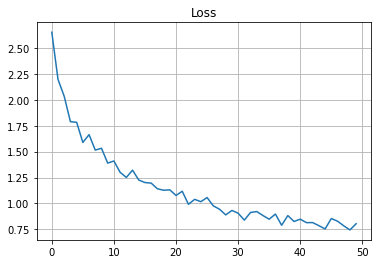

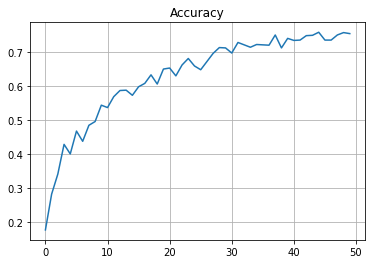

In [26]:
from tqdm import trange

def train(category, category_tensor, line_tensor, optimizer):
    hidden = rnncell.initHidden()

    rnncell.zero_grad()
    classifier.zero_grad()

    for letter_tensor in line_tensor:
        hidden = rnncell(letter_tensor, hidden)#code here, прокручиваем через рекурентную сеть новую букву и старой скрытое состояние
        
    output = classifier(hidden)#применяем классификатор как будто бы это последний слой в сети

    loss = F.nll_loss(output, category_tensor)
    loss.backward()
    optimizer.step()
    
    acc = (categoryFromOutput(output)[0] == category)

    return loss.item(), acc

n_iters = 50000
plot_every = 1000

current_loss = 0
all_losses = []
current_acc = 0
all_accs = []

n_hidden = 128

rnncell = RNNCell(n_letters, n_hidden)
classifier = nn.Sequential(nn.Linear(n_hidden, n_categories), nn.LogSoftmax(dim=1))
params = list(rnncell.parameters()) + list(classifier.parameters())
opt = torch.optim.RMSprop(params, lr=0.001)
for iter in trange(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    loss, acc = train(category, category_tensor, line_tensor, opt)
    current_loss += loss
    current_acc += acc

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        all_accs.append(current_acc / plot_every)
        current_acc = 0
        
plt.figure()
plt.title("Loss")
plt.plot(all_losses)
plt.grid()
plt.show()

plt.figure()
plt.title("Accuracy")
plt.plot(all_accs)
plt.grid()
plt.show()

## Затухающие и взрывающиеся градиенты

Эксперименты будем проводить опять на датасете MNIST, но будем работать с полносвязными сетями. В этом разделе мы не будем пытаться подобрать более удачную архитектуру, нам интересно только посмотреть на особенности обучения глубоких сетей.

In [1]:
import sys; import pickle; import gzip;
f = gzip.open('mnist.pkl.gz', 'rb')
if sys.version_info < (3,):
    data = pickle.load(f)
else:
    data = pickle.load(f, encoding='bytes')
f.close()

#(X_train, y_train), (X_val, y_val) = (None, None), (None, None)
(X_train, y_train), (X_val,y_val) = data

In [5]:
def convert(y_batch):
    y_batch = y_batch.astype(np.int64)
    new_batch = np.zeros((32, 10))
    for i in range(32):
        new_batch[i][y_batch[i]] = 1
    y_batch = new_batch
    return y_batch

In [6]:
def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for x_batch, y_batch in iterate_minibatches(X_val, y_val, batchsize=32, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        y_batch = convert(y_batch)
        target = torch.from_numpy(y_batch.astype(np.int64))
        
        output = model(data)
        loss = F.nll_loss(output, target)
        
        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

Для экспериментов нам понадобится сеть, в которой можно легко менять количество слоев. Также эта сеть должна сохранять градиенты на всех слоях, чтобы потом мы могли посмотреть на их величины.

In [7]:
class DeepDenseNet(nn.Module):
    def __init__(self, n_layers, hidden_size, activation):
        super().__init__()
        self.activation = activation
        
        l0 = nn.Linear(X_train.shape[1], hidden_size)
        self.weights = [l0.weight]
        self.layers = [l0]
        
        for i in range(n_layers):
            self.layers.append(self.activation)
            linear = nn.Linear(hidden_size, hidden_size)
            self.layers.append(linear)
            self.weights.append(linear.weight)
        
        self.seq = nn.Sequential(*self.layers)
        
        for l in self.weights:
            l.retain_grad()
        
    def forward(self, x):
        out = self.seq(x)
        return F.log_softmax(out, dim=-1)

Модифицируем наши функции обучения, чтобы они также рисовали графики изменения градиентов.

In [8]:
import scipy.sparse.linalg

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def train_epoch_grad(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    grads = [[] for l in model.weights]
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        # data preparation
        y_batch = convert(y_batch)
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))
        
        optimizer.zero_grad()
        output = model(data)
        
        pred = torch.max(output, 1)[1].cpu().numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
        
        for g, l in zip(grads, model.weights):
            g.append(np.linalg.norm(l.grad.cpu().numpy()))
    return loss_log, acc_log, grads


def train_grad(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    grads_log = None

    batchsize = 32

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss, train_acc, grads = train_epoch_grad(model, opt, batchsize=batchsize)
        if grads_log is None:
            grads_log = grads
        else:
            for a, b in zip(grads_log, grads):
                a.extend(b)
        
        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(X_train) / batchsize
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        #display all metrics
        #clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')    

        plt.figure()
        all_vals = []
        for i, g in enumerate(grads_log):
            w = np.ones(100)
            w /= w.sum()
            vals = np.convolve(w, g, mode='valid')
            plt.semilogy(vals, label=str(i+1), color=plt.cm.coolwarm((i / len(grads_log))))
            all_vals.extend(vals)
        plt.legend(loc='best')
        plt.grid()
        plt.show()

**Задание 4 (1 балл):**
* Обучите сети глубины 10 и больше с сигмоидой в качестве активации. Исследуйте, как глубина влияет на качество обучения и поведение градиентов на далеких от выхода слоях.

In [9]:
X_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

Epoch 0 of 10


100%|██████████| 312/312 [00:00<00:00, 679.79it/s]


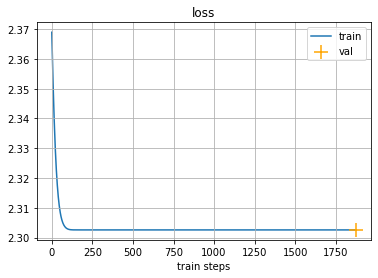

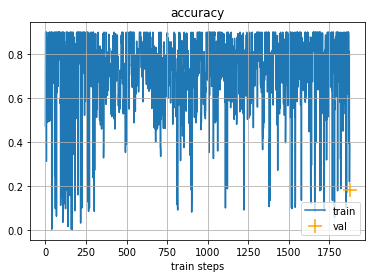

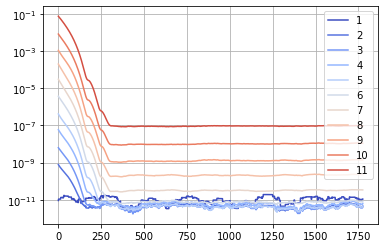

Epoch 1 of 10


100%|██████████| 312/312 [00:00<00:00, 682.75it/s]


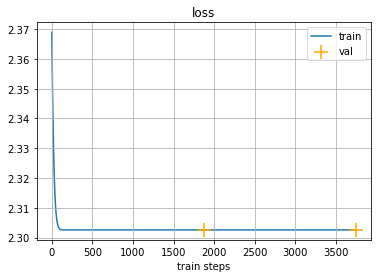

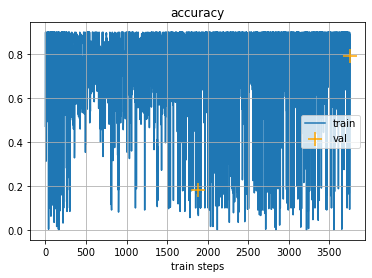

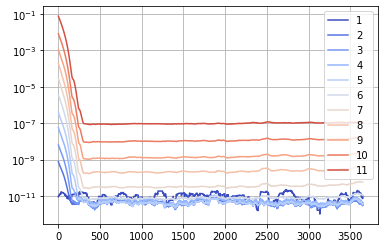

Epoch 2 of 10


100%|██████████| 312/312 [00:00<00:00, 620.10it/s]


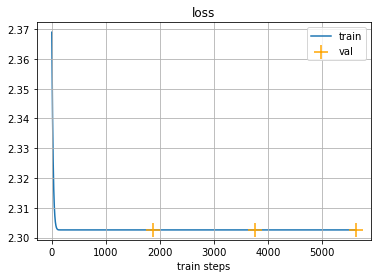

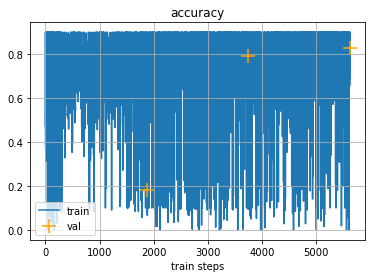

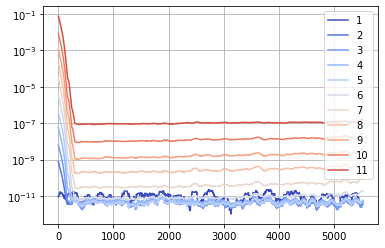

Epoch 3 of 10


100%|██████████| 312/312 [00:00<00:00, 685.54it/s]


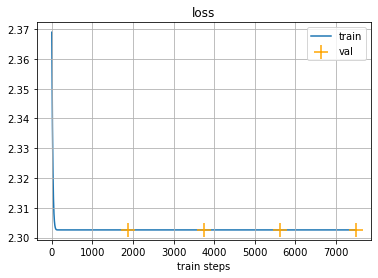

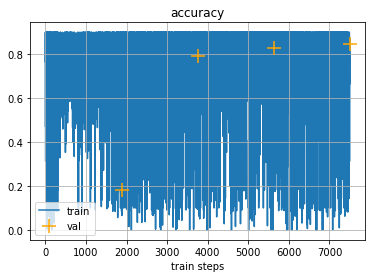

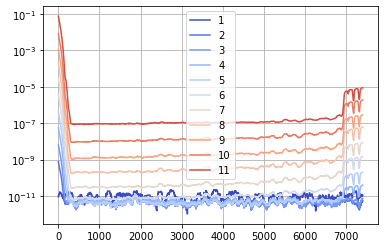

Epoch 4 of 10


100%|██████████| 312/312 [00:00<00:00, 681.93it/s]


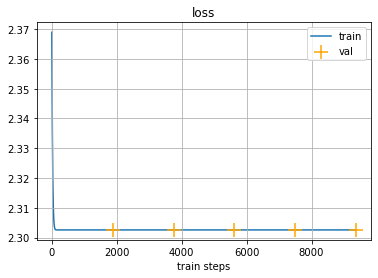

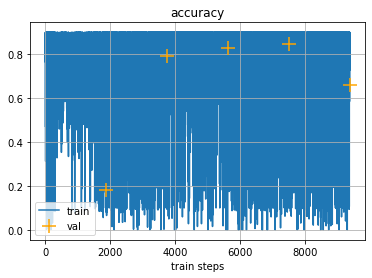

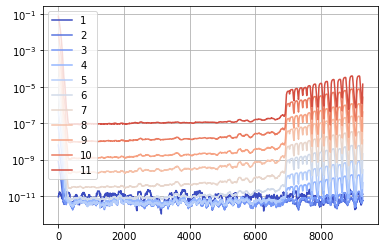

Epoch 5 of 10


100%|██████████| 312/312 [00:00<00:00, 655.37it/s]


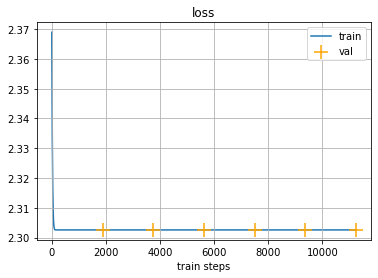

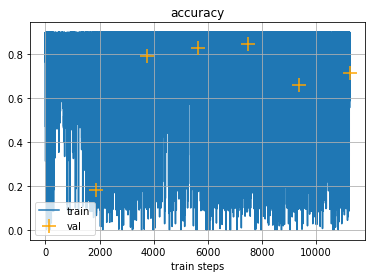

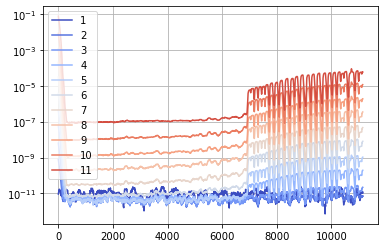

Epoch 6 of 10


100%|██████████| 312/312 [00:00<00:00, 671.69it/s]


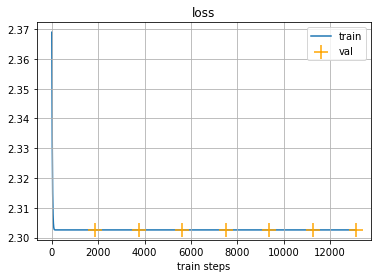

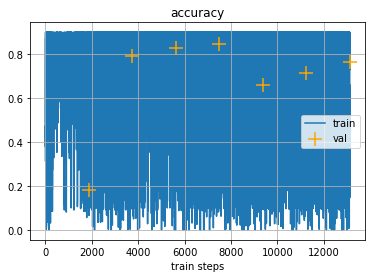

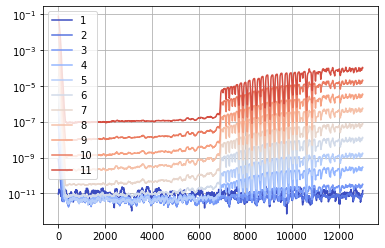

Epoch 7 of 10


100%|██████████| 312/312 [00:00<00:00, 675.79it/s]


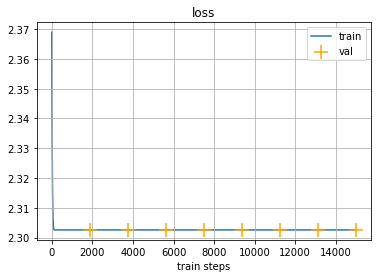

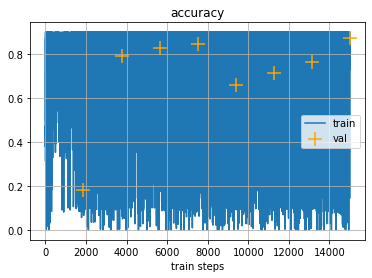

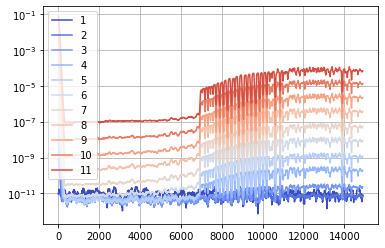

Epoch 8 of 10


100%|██████████| 312/312 [00:00<00:00, 681.49it/s]


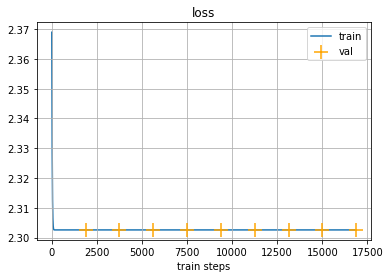

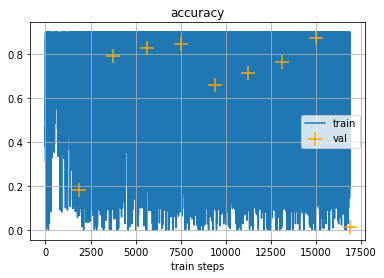

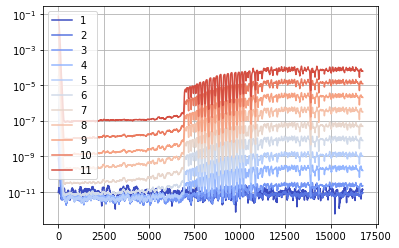

Epoch 9 of 10


100%|██████████| 312/312 [00:00<00:00, 700.86it/s]


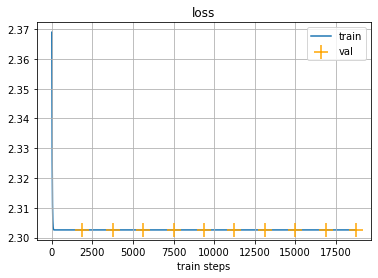

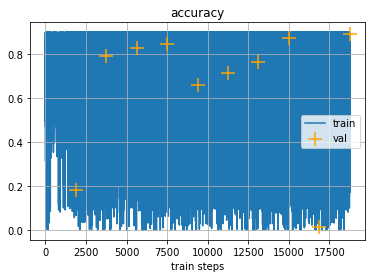

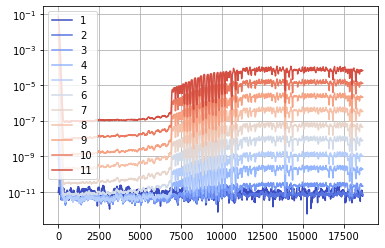

In [12]:
model = DeepDenseNet(10, 10, nn.Sigmoid())
train_grad(model, torch.optim.Adam(model.parameters()), 10)

Epoch 0 of 10


100%|██████████| 312/312 [00:03<00:00, 81.60it/s]


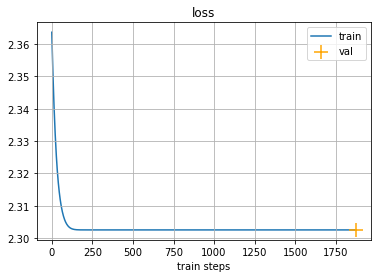

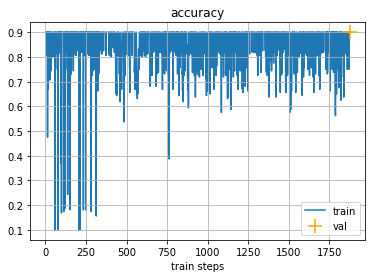

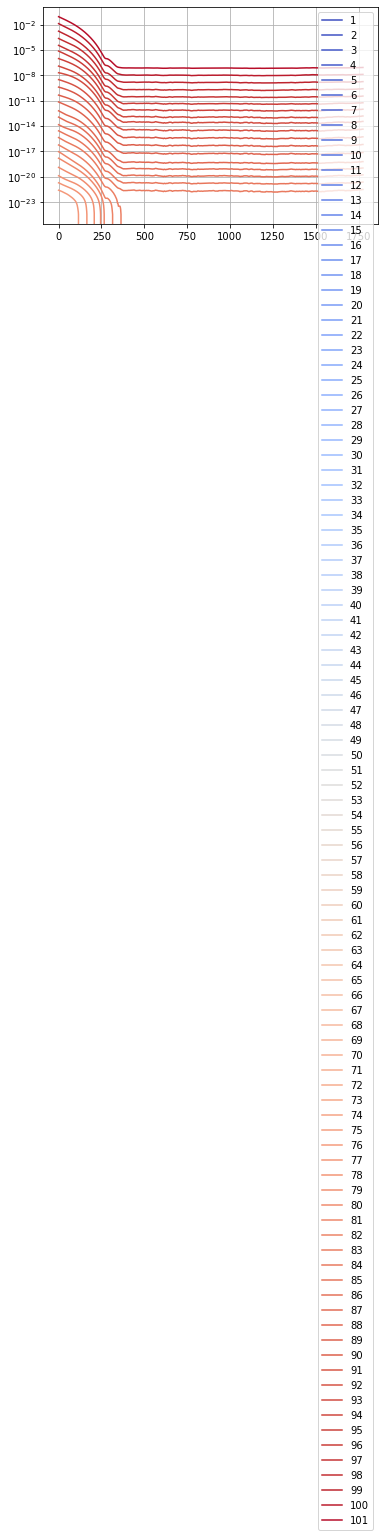

Epoch 1 of 10


100%|██████████| 312/312 [00:03<00:00, 83.33it/s]


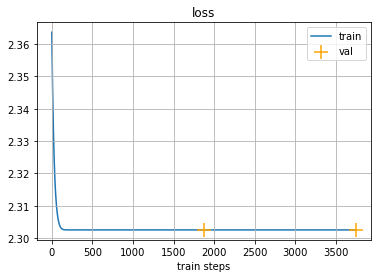

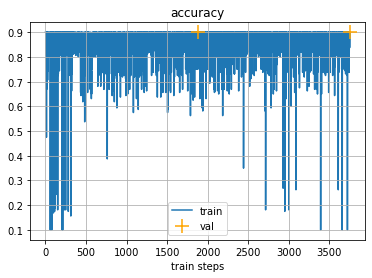

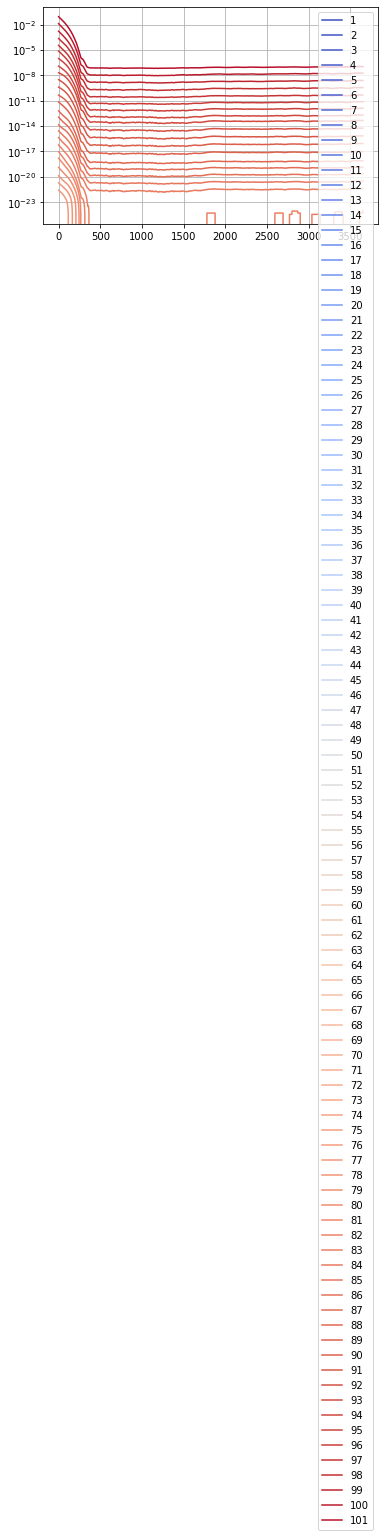

Epoch 2 of 10


100%|██████████| 312/312 [00:03<00:00, 80.07it/s]


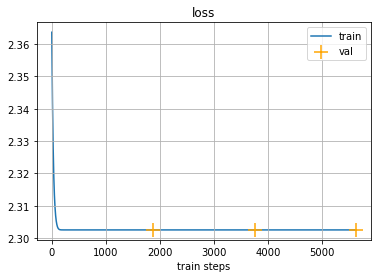

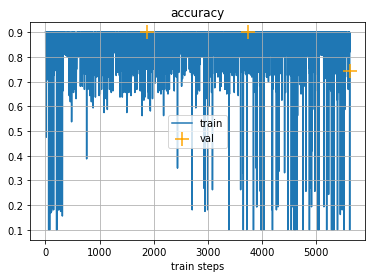

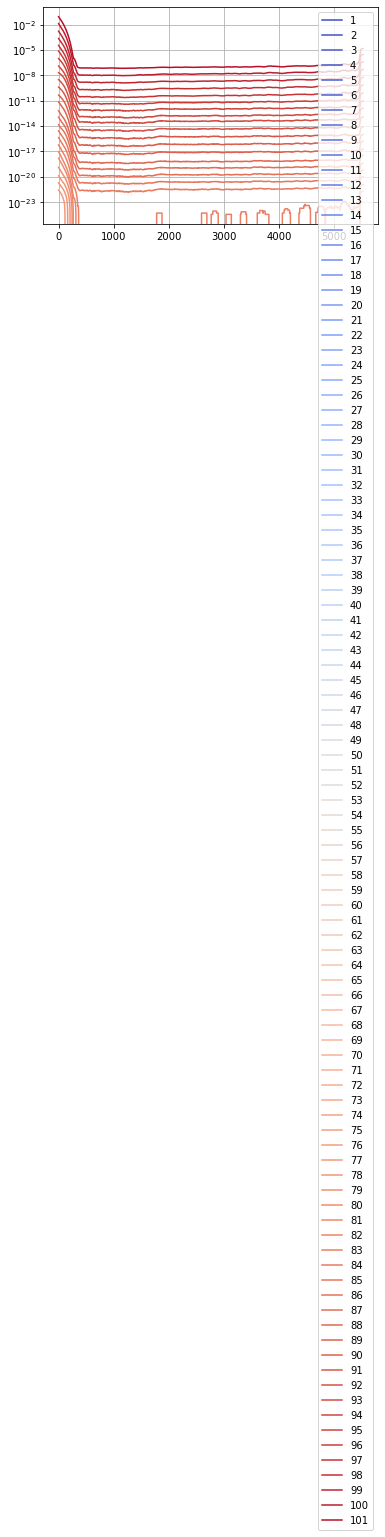

Epoch 3 of 10


100%|██████████| 312/312 [00:03<00:00, 87.48it/s]


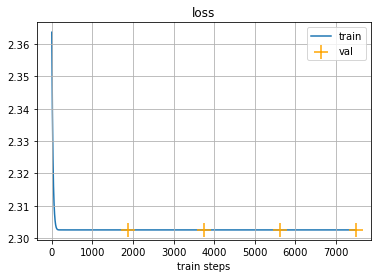

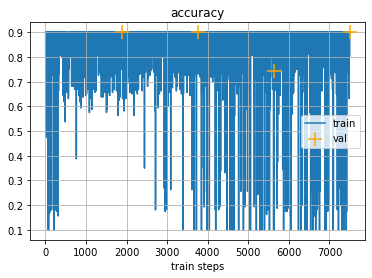

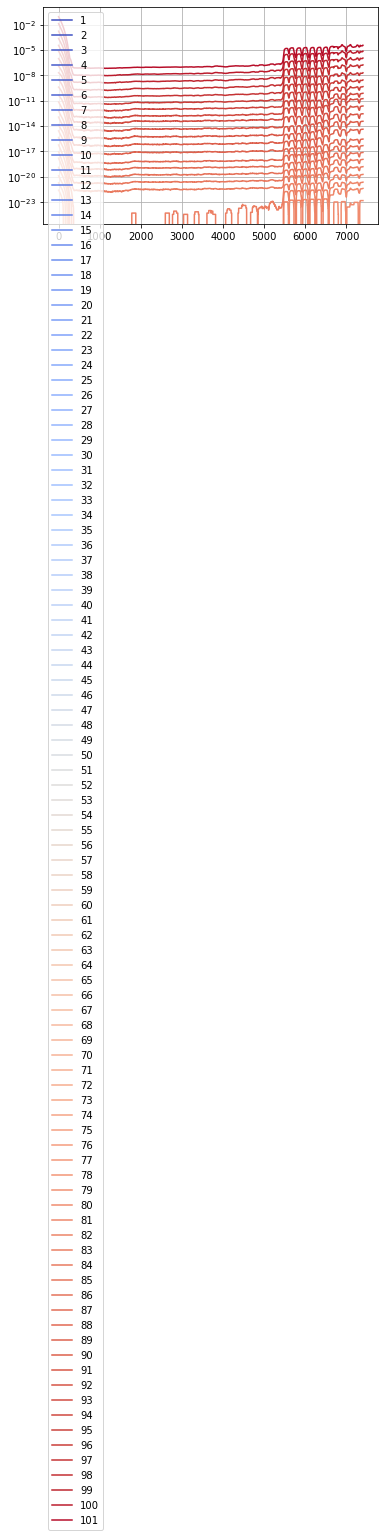

Epoch 4 of 10


100%|██████████| 312/312 [00:03<00:00, 83.72it/s]


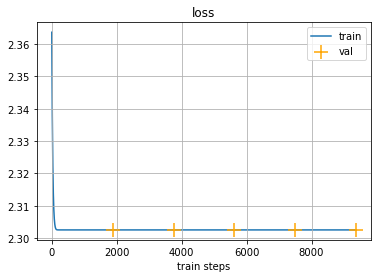

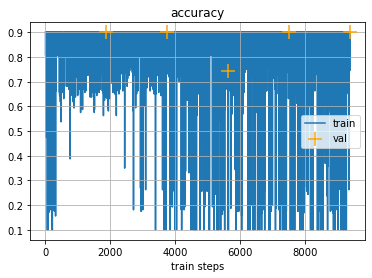

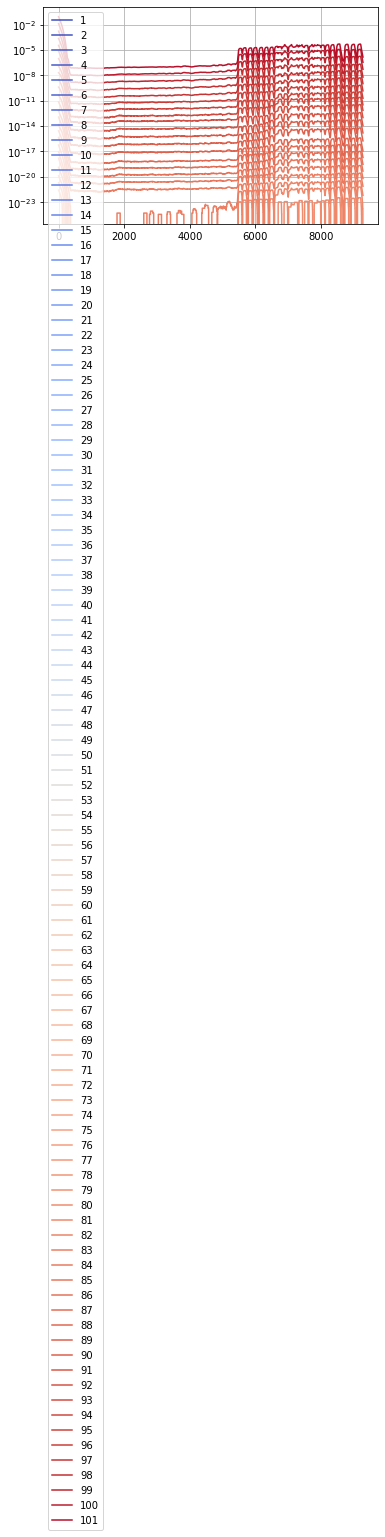

Epoch 5 of 10


100%|██████████| 312/312 [00:03<00:00, 84.11it/s]


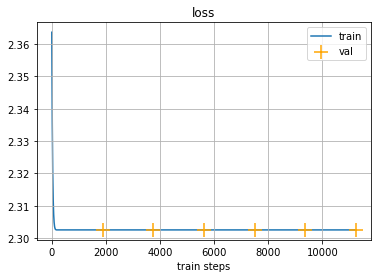

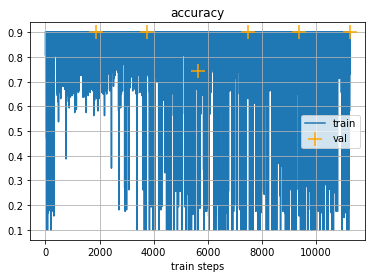

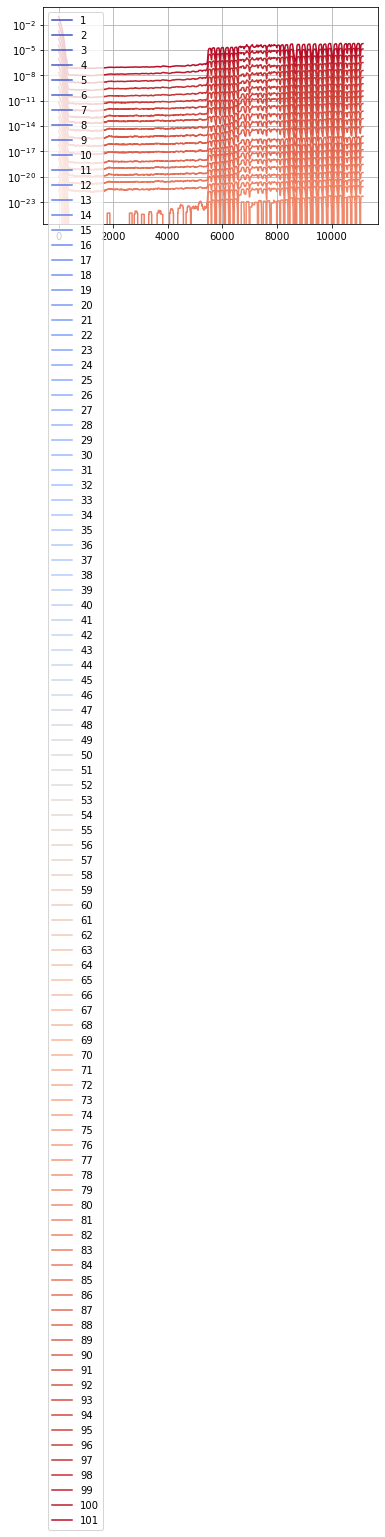

Epoch 6 of 10


100%|██████████| 312/312 [00:04<00:00, 76.96it/s]


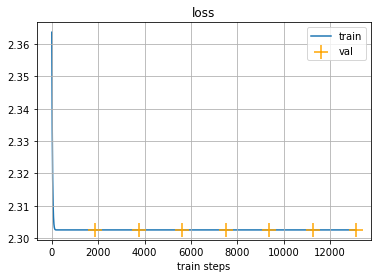

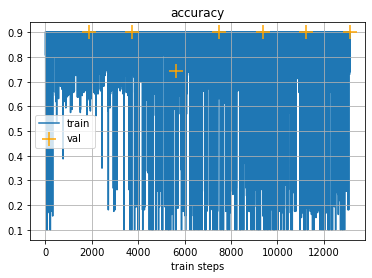

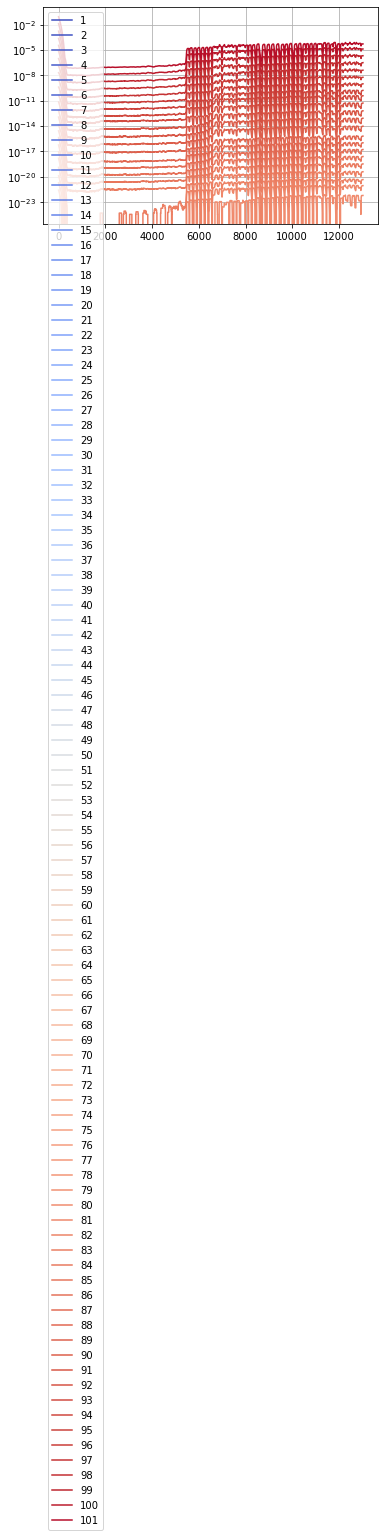

Epoch 7 of 10


100%|██████████| 312/312 [00:03<00:00, 79.57it/s]


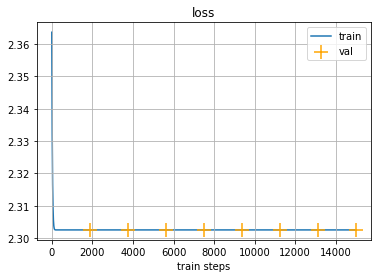

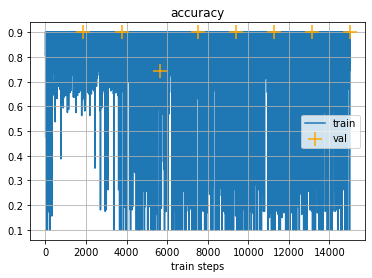

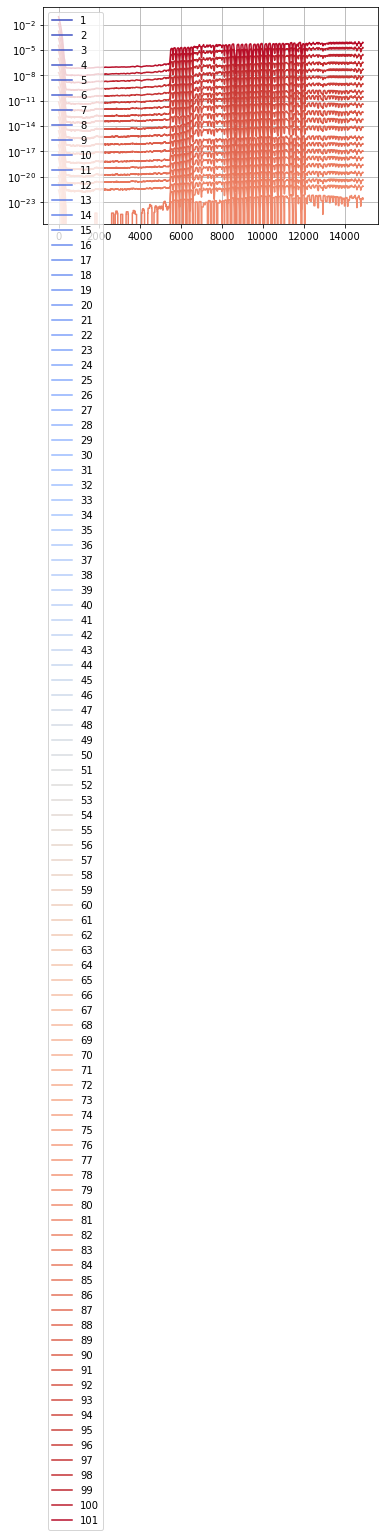

Epoch 8 of 10


100%|██████████| 312/312 [00:03<00:00, 78.77it/s]


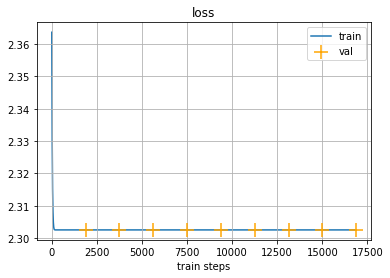

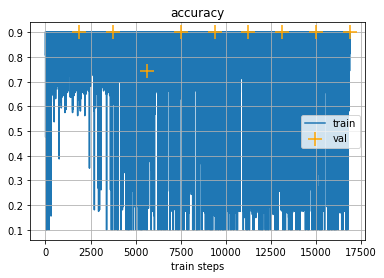

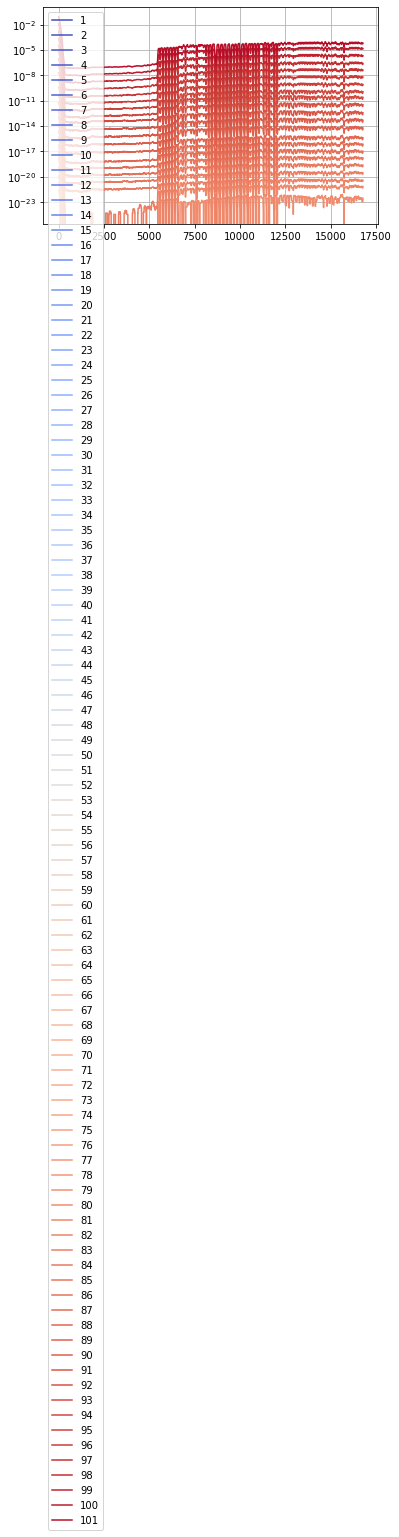

Epoch 9 of 10


100%|██████████| 312/312 [00:03<00:00, 83.46it/s]


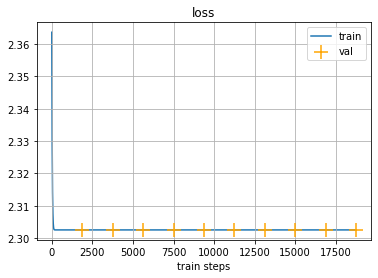

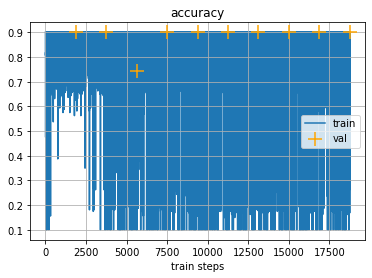

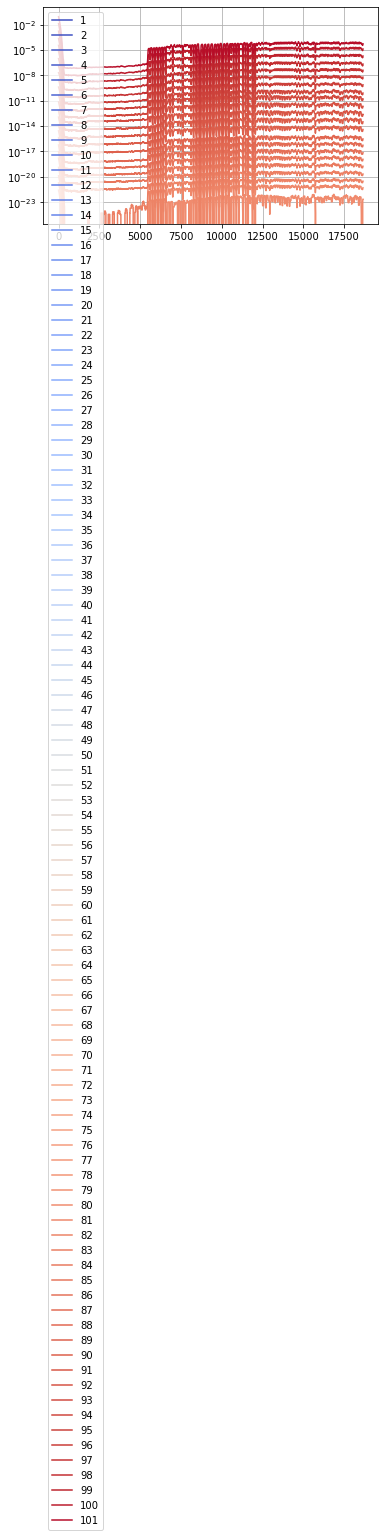

In [14]:
model = DeepDenseNet(100, 10, nn.Sigmoid())
train_grad(model, torch.optim.Adam(model.parameters()), 10)

Epoch 0 of 10


100%|██████████| 312/312 [00:00<00:00, 1741.66it/s]


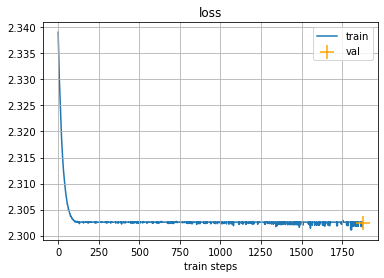

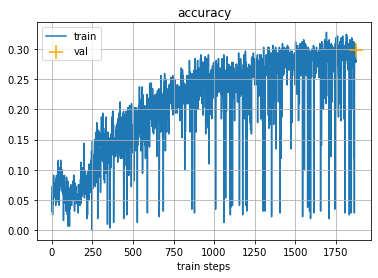

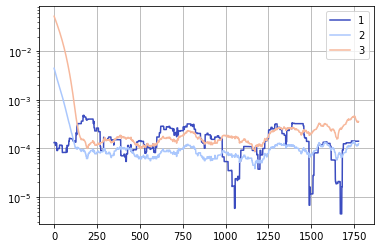

Epoch 1 of 10


100%|██████████| 312/312 [00:00<00:00, 1693.47it/s]


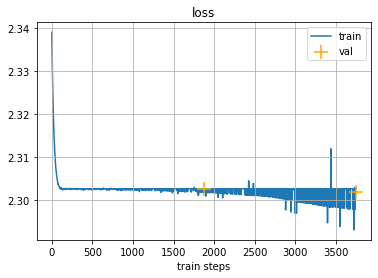

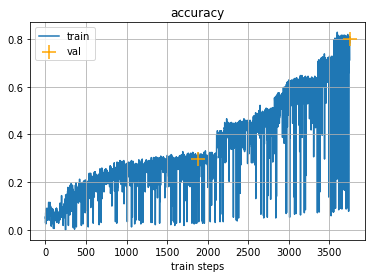

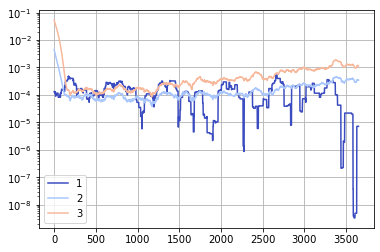

Epoch 2 of 10


100%|██████████| 312/312 [00:00<00:00, 1612.20it/s]


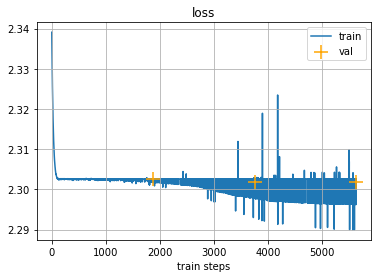

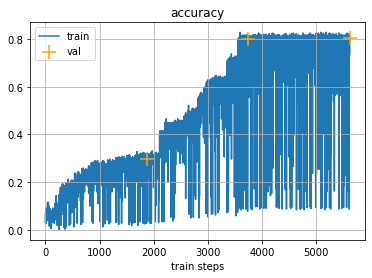

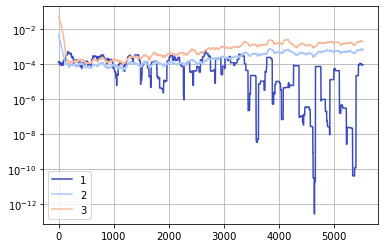

Epoch 3 of 10


100%|██████████| 312/312 [00:00<00:00, 1752.55it/s]


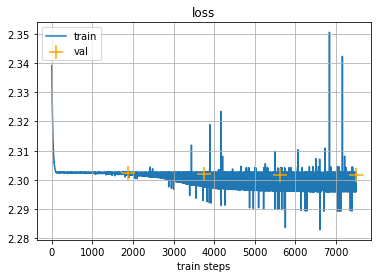

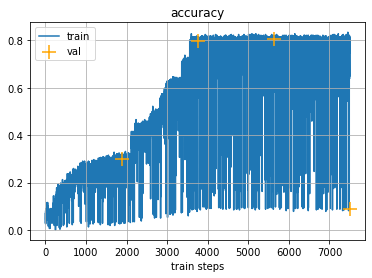

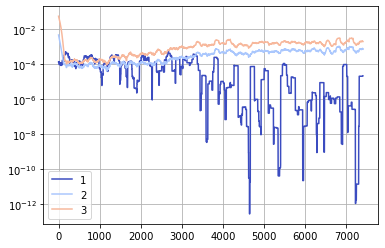

Epoch 4 of 10


100%|██████████| 312/312 [00:00<00:00, 1656.63it/s]


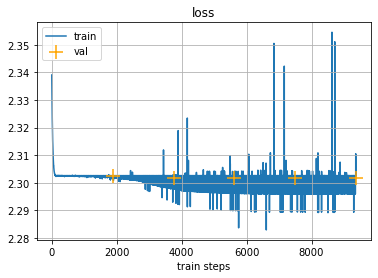

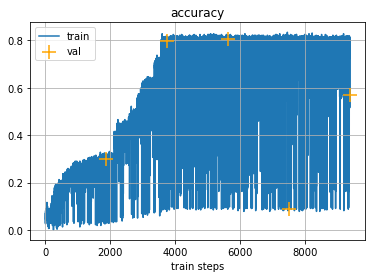

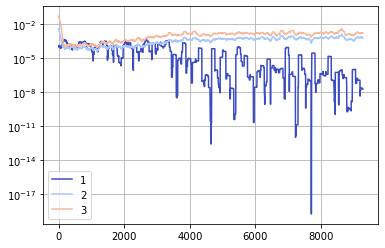

Epoch 5 of 10


100%|██████████| 312/312 [00:00<00:00, 1780.33it/s]


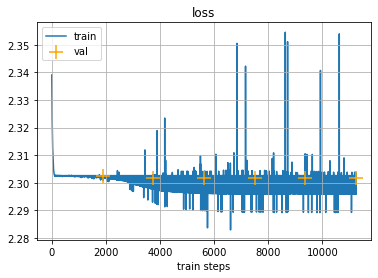

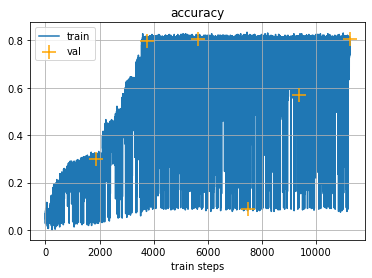

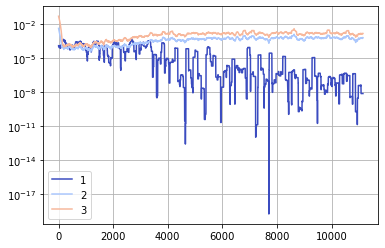

Epoch 6 of 10


100%|██████████| 312/312 [00:00<00:00, 1626.67it/s]


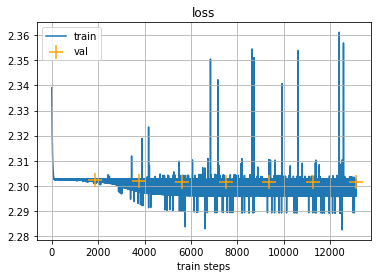

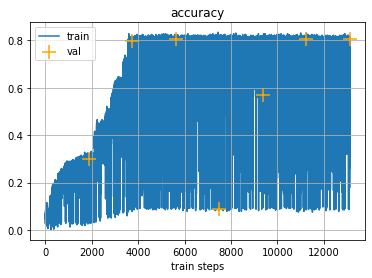

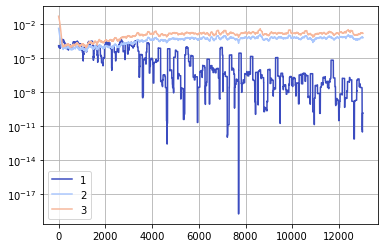

Epoch 7 of 10


100%|██████████| 312/312 [00:00<00:00, 1795.95it/s]


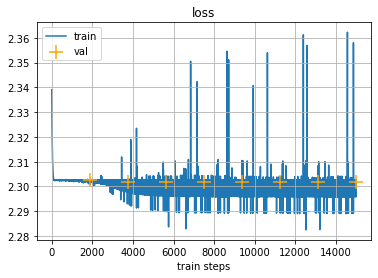

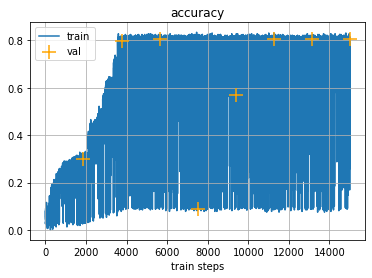

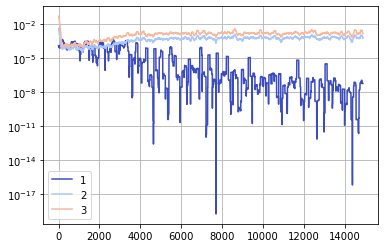

Epoch 8 of 10


100%|██████████| 312/312 [00:00<00:00, 1761.72it/s]


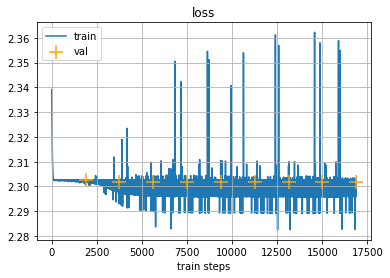

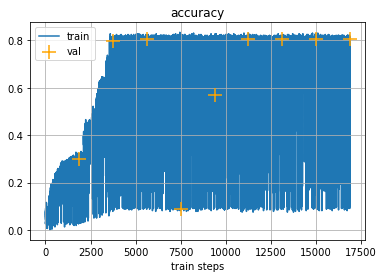

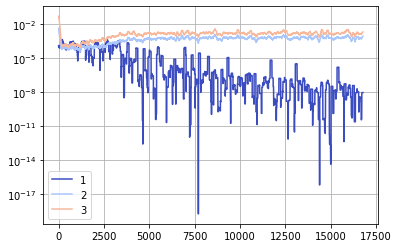

Epoch 9 of 10


100%|██████████| 312/312 [00:00<00:00, 1754.16it/s]


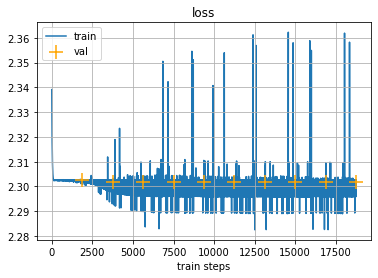

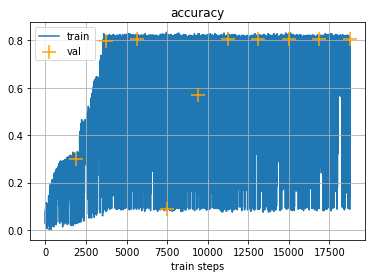

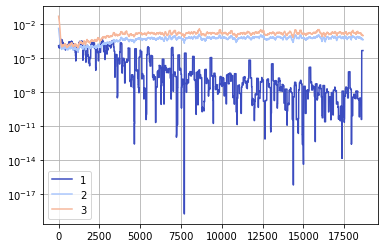

In [15]:
model = DeepDenseNet(2, 10, nn.Sigmoid())
train_grad(model, torch.optim.Adam(model.parameters()), 10)

Epoch 0 of 10


100%|██████████| 312/312 [00:00<00:00, 386.38it/s]


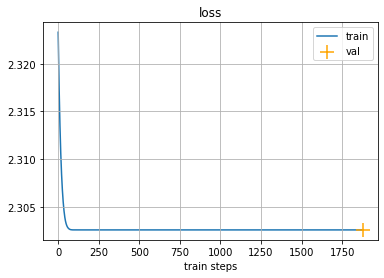

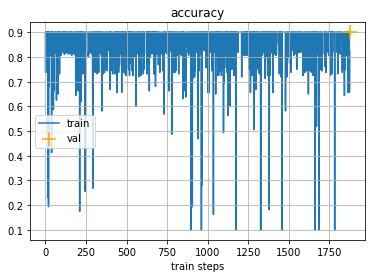

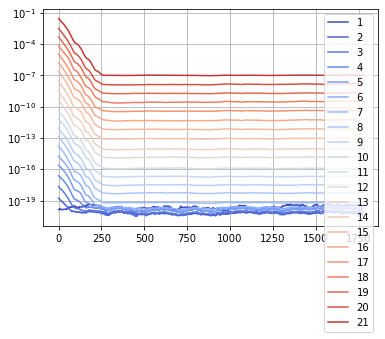

Epoch 1 of 10


100%|██████████| 312/312 [00:00<00:00, 380.69it/s]


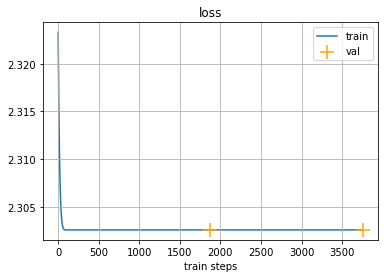

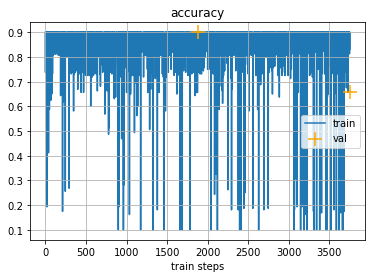

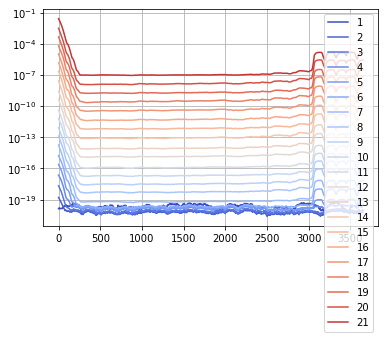

Epoch 2 of 10


100%|██████████| 312/312 [00:00<00:00, 351.95it/s]


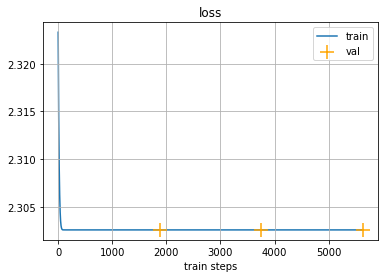

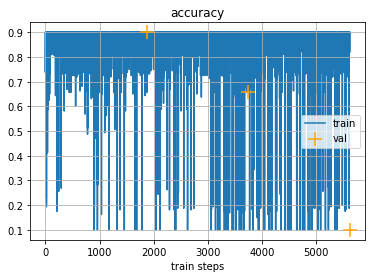

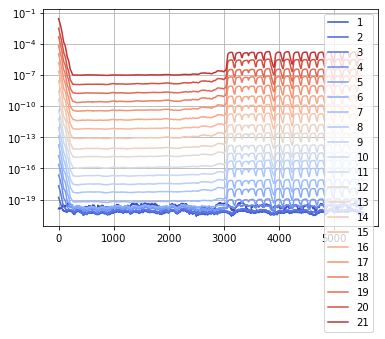

Epoch 3 of 10


100%|██████████| 312/312 [00:00<00:00, 383.35it/s]


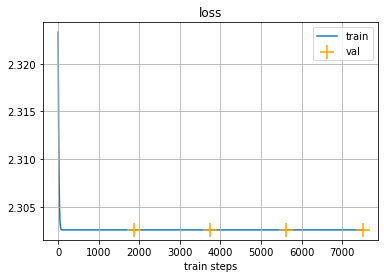

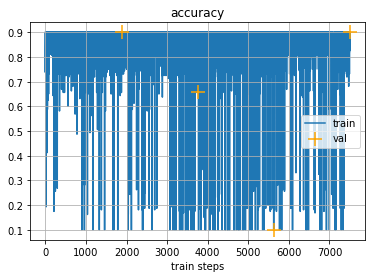

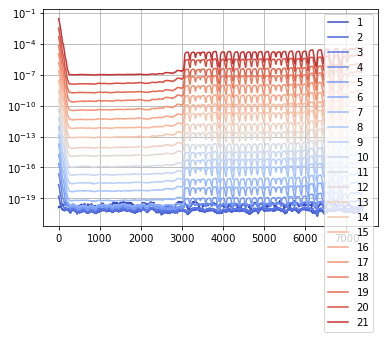

Epoch 4 of 10


100%|██████████| 312/312 [00:00<00:00, 386.01it/s]


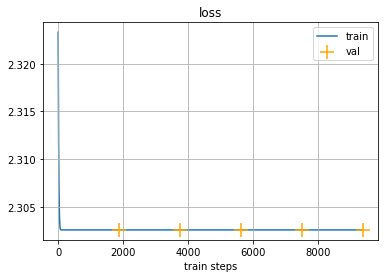

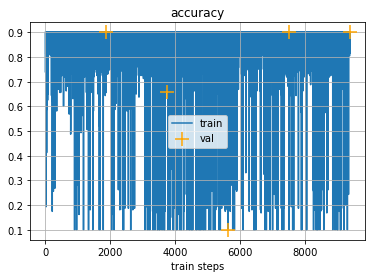

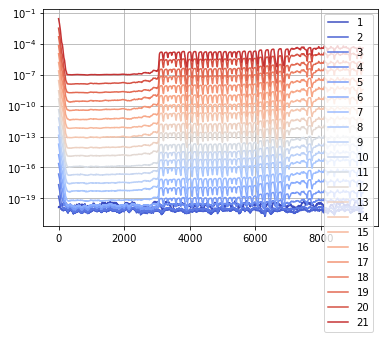

Epoch 5 of 10


100%|██████████| 312/312 [00:00<00:00, 383.20it/s]


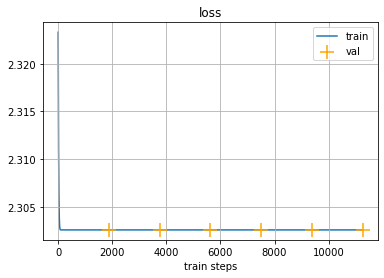

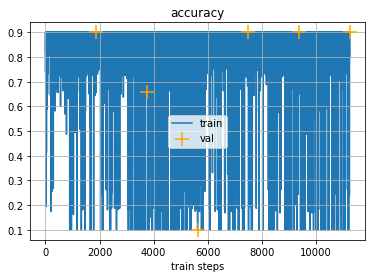

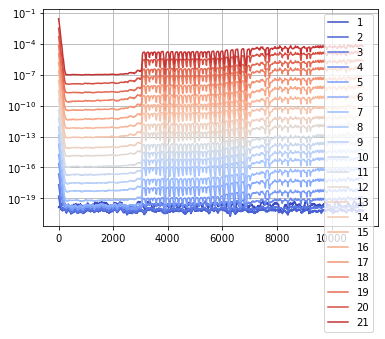

Epoch 6 of 10


100%|██████████| 312/312 [00:00<00:00, 390.82it/s]


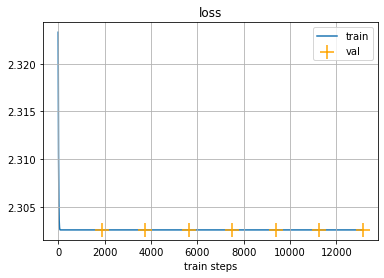

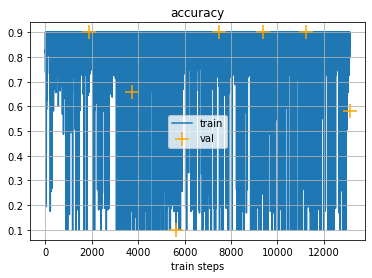

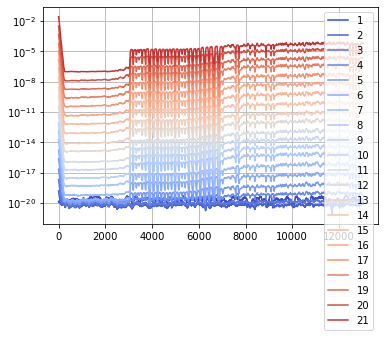

Epoch 7 of 10


100%|██████████| 312/312 [00:00<00:00, 391.95it/s]


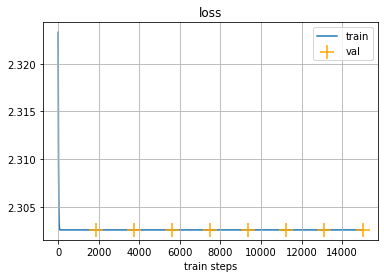

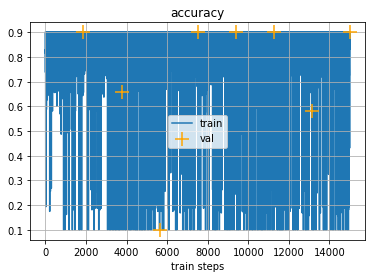

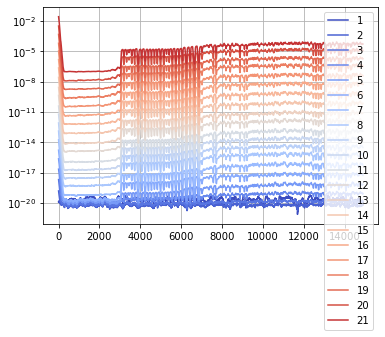

Epoch 8 of 10


100%|██████████| 312/312 [00:00<00:00, 371.06it/s]


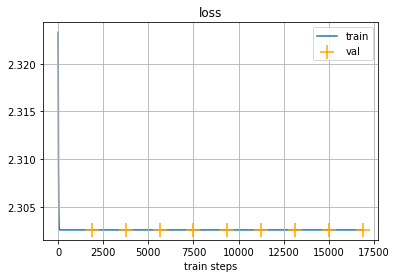

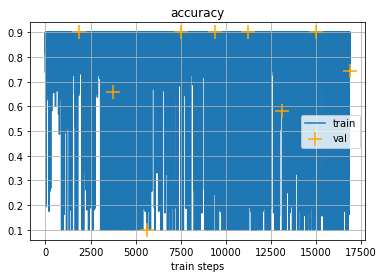

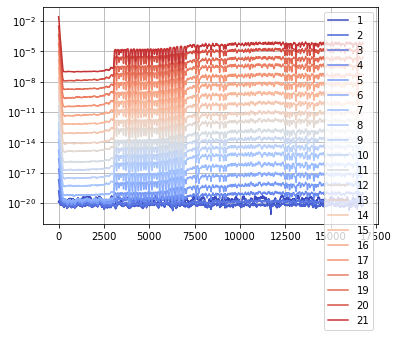

Epoch 9 of 10


100%|██████████| 312/312 [00:00<00:00, 407.85it/s]


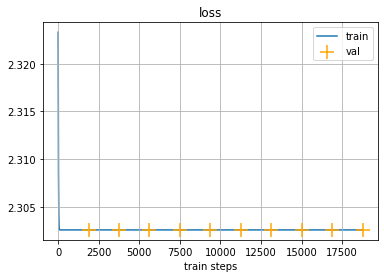

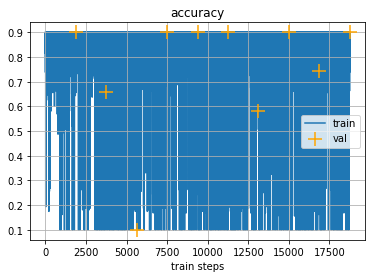

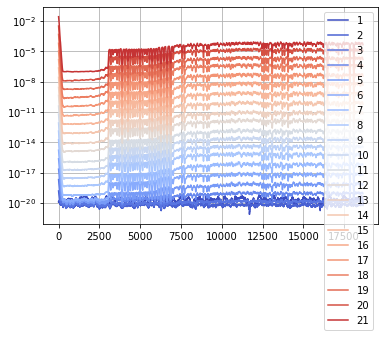

In [16]:
model = DeepDenseNet(20, 10, nn.Sigmoid())
train_grad(model, torch.optim.Adam(model.parameters()), 10)

* Теперь замените активацию на ReLU и посмотрите, что получится.

Epoch 0 of 10


100%|██████████| 312/312 [00:00<00:00, 591.39it/s]


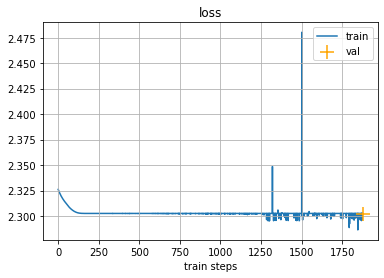

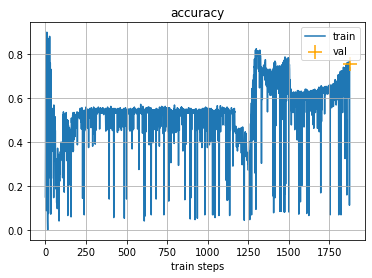

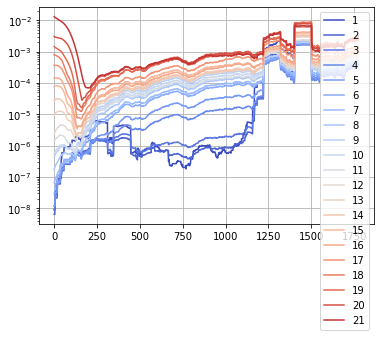

Epoch 1 of 10


100%|██████████| 312/312 [00:00<00:00, 675.24it/s]


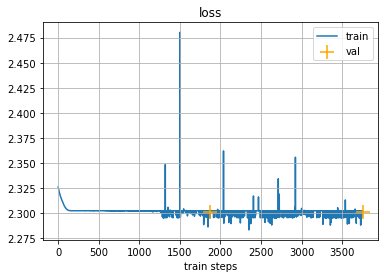

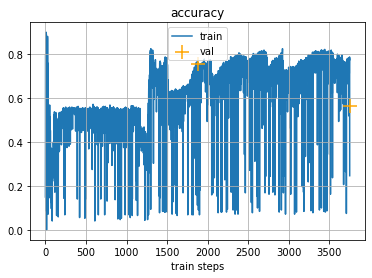

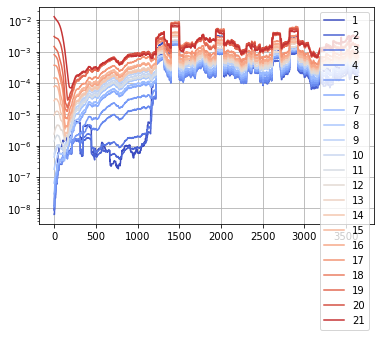

Epoch 2 of 10


100%|██████████| 312/312 [00:00<00:00, 608.67it/s]


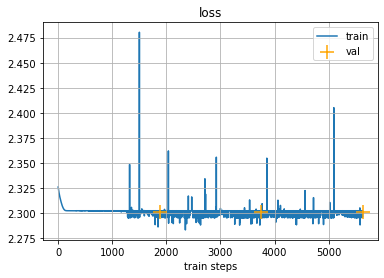

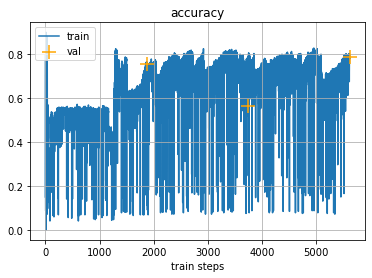

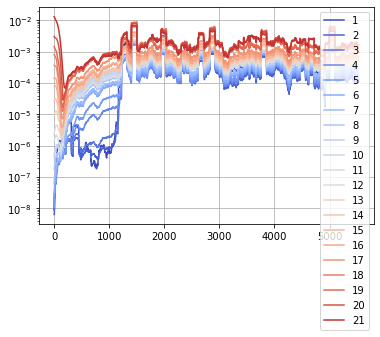

Epoch 3 of 10


100%|██████████| 312/312 [00:00<00:00, 636.18it/s]


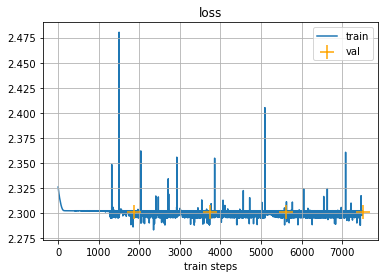

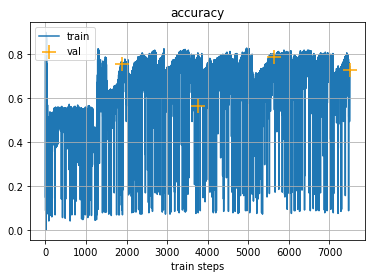

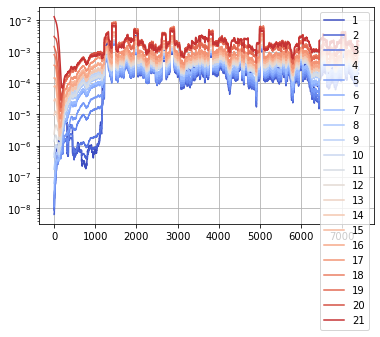

Epoch 4 of 10


100%|██████████| 312/312 [00:00<00:00, 591.35it/s]


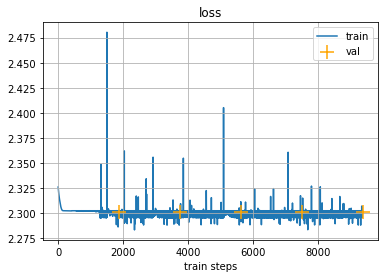

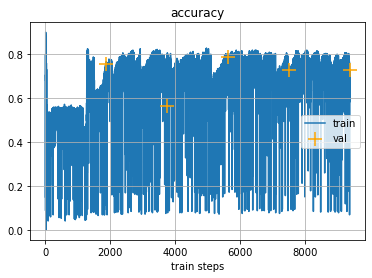

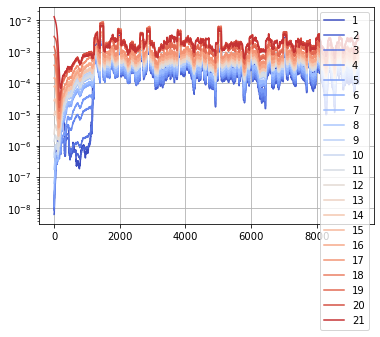

Epoch 5 of 10


100%|██████████| 312/312 [00:00<00:00, 640.32it/s]


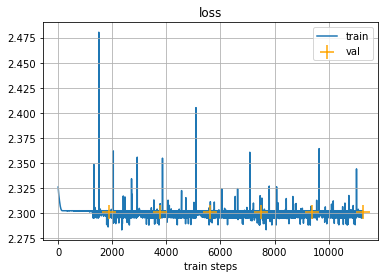

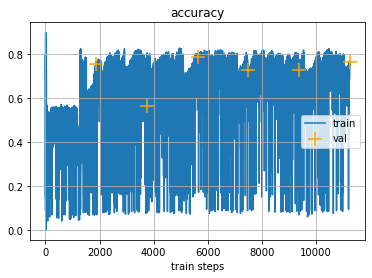

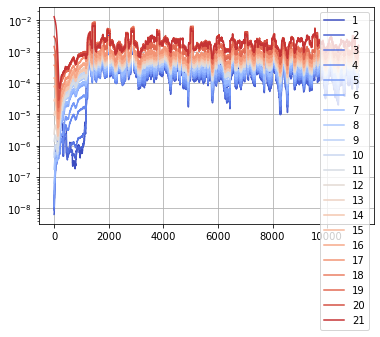

Epoch 6 of 10


100%|██████████| 312/312 [00:00<00:00, 690.90it/s]


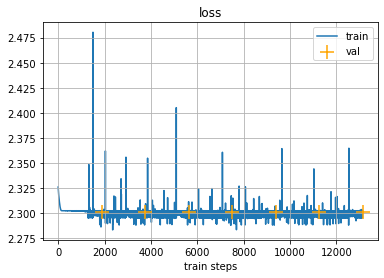

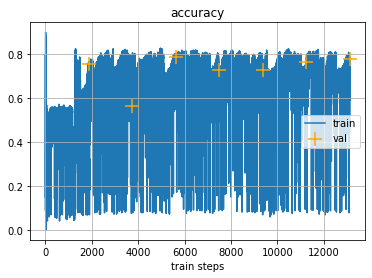

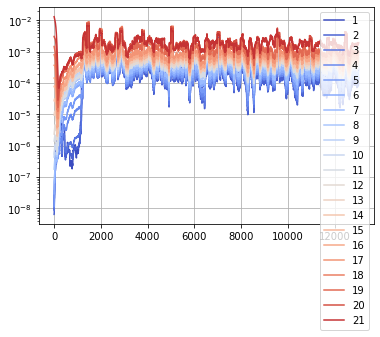

Epoch 7 of 10


100%|██████████| 312/312 [00:00<00:00, 703.38it/s]


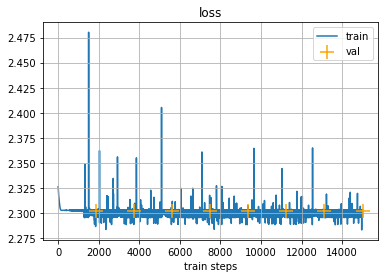

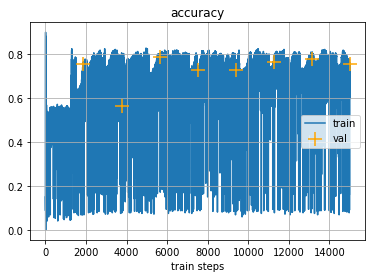

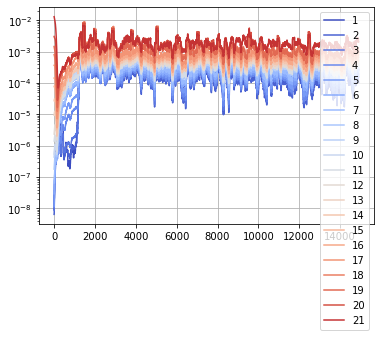

Epoch 8 of 10


100%|██████████| 312/312 [00:00<00:00, 679.25it/s]


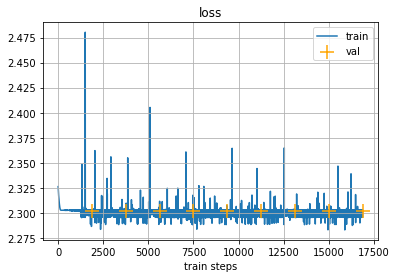

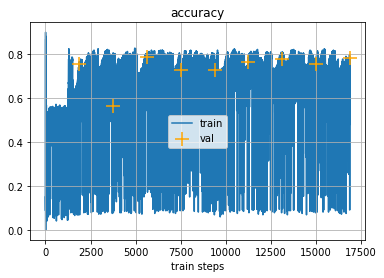

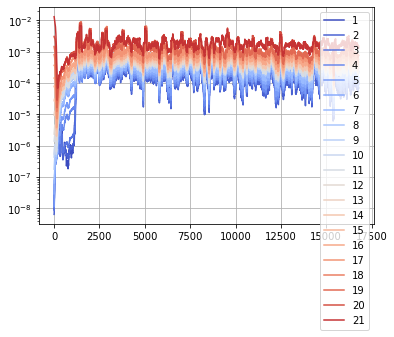

Epoch 9 of 10


100%|██████████| 312/312 [00:00<00:00, 696.72it/s]


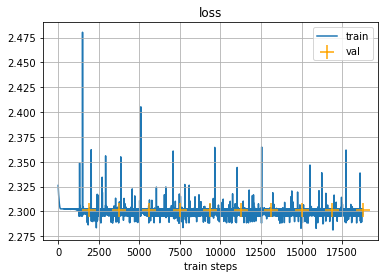

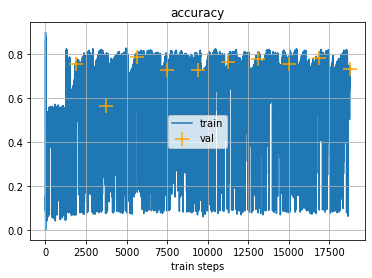

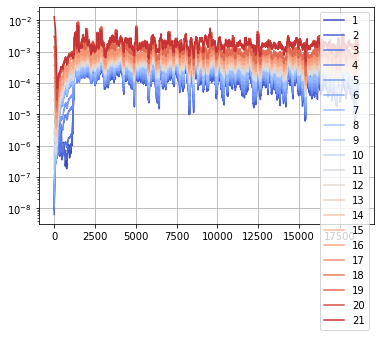

In [17]:
model = DeepDenseNet(20, 10, nn.ReLU())
train_grad(model, torch.optim.Adam(model.parameters()), 10)

Теперь попробуем добавить в сеть skip-connections (по примеру ResNet) вместо замены сигмоиды на relu и посмотрим, что получится. Запихнуть все слои в nn.Sequential и просто их применить теперь не получится - вместо этого мы их применим вручную. Но положить их в отдельный модуль nn.Sequential все равно нужно, иначе torch не сможет их найти и оптимизировать.

**Задание 5 (4 балла):** допишите недостающую часть кода ниже.

In [26]:
class DeepDenseResNet(nn.Module):
    def __init__(self, n_layers, hidden_size, activation):
        super().__init__()
        self.activation = activation
        
        l0 = nn.Linear(X_train.shape[1], hidden_size)
        self.weights = [l0.weight]
        self.layers = [l0]
        
        for i in range(1, n_layers - 1):
            l = nn.Linear(hidden_size, hidden_size)
            self.layers.append(l)
            self.weights.append(l.weight)
            
        l = nn.Linear(hidden_size, 10)
        self.layers.append(l)
        self.weights.append(l.weight)
        
        self.seq = nn.Sequential(*self.layers)
        
        for l in self.weights:
            l.retain_grad()
        
    def forward(self, x):
        residual = x  
        out = x
        for i in range(len(self.layers) - 1):
            out = self.activation(self.layers[i](out))
            if i < len(self.layers) - 2:
                if out.shape != residual.shape:  
                    residual = self.layers[i](residual)  
                out = out + residual 
                residual = out 
        out = self.layers[-1](out)  
        return F.log_softmax(out, dim=-1)

Убедимся, что такая сеть отлично учится даже на большом числе слоев.

Epoch 0 of 10


100%|██████████| 312/312 [00:00<00:00, 421.95it/s]


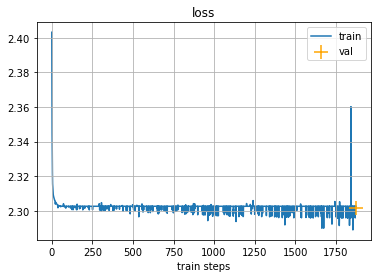

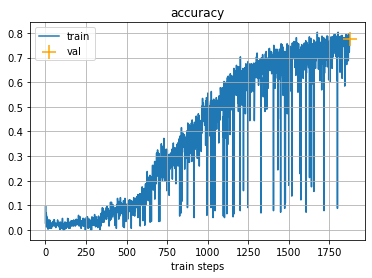

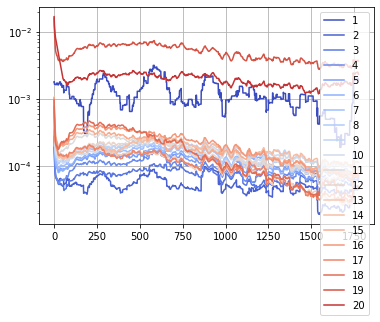

Epoch 1 of 10


100%|██████████| 312/312 [00:00<00:00, 455.17it/s]


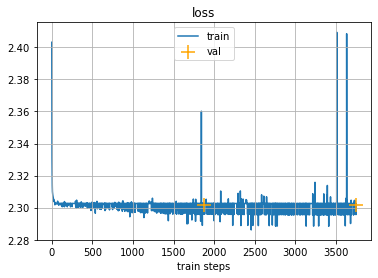

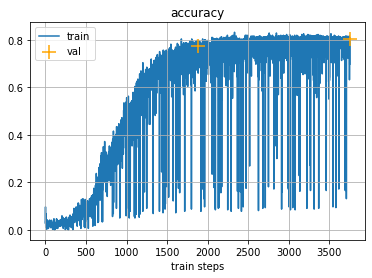

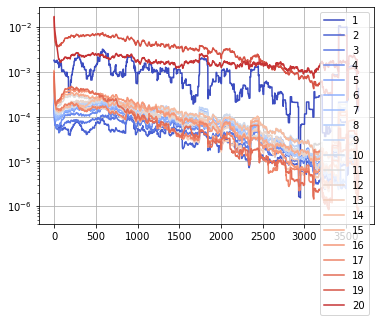

Epoch 2 of 10


100%|██████████| 312/312 [00:00<00:00, 362.54it/s]


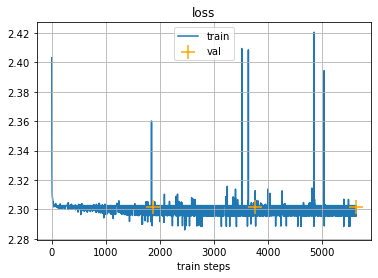

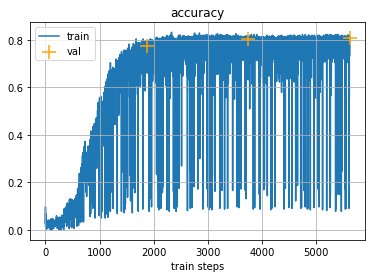

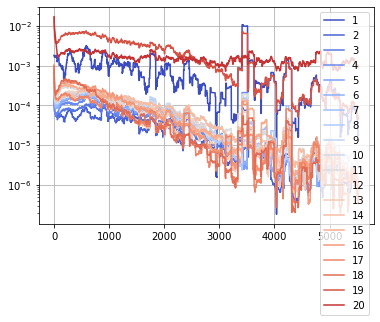

Epoch 3 of 10


100%|██████████| 312/312 [00:00<00:00, 434.79it/s]


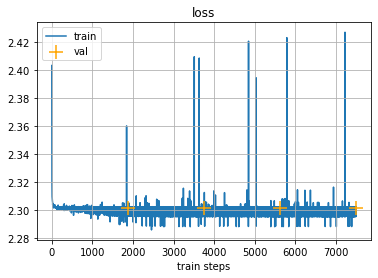

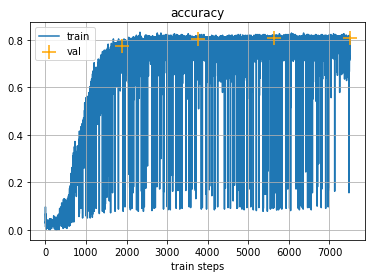

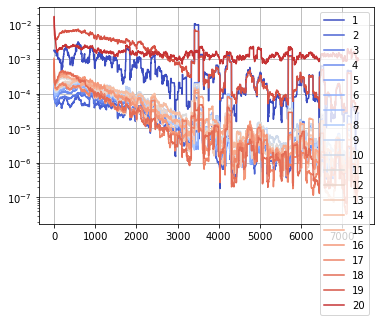

Epoch 4 of 10


100%|██████████| 312/312 [00:00<00:00, 468.05it/s]


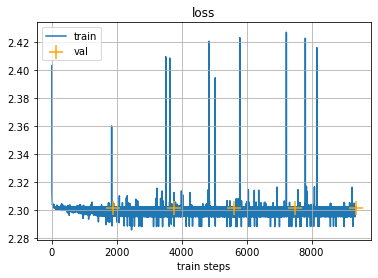

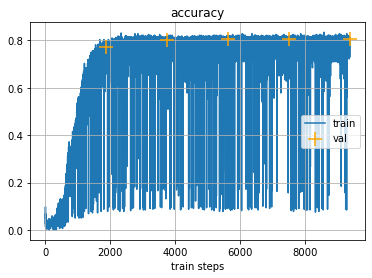

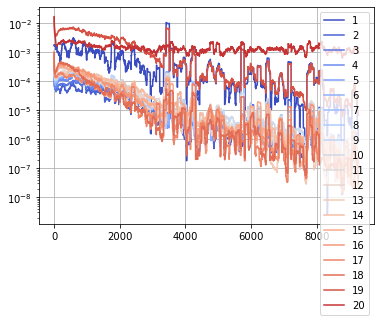

Epoch 5 of 10


100%|██████████| 312/312 [00:00<00:00, 439.31it/s]


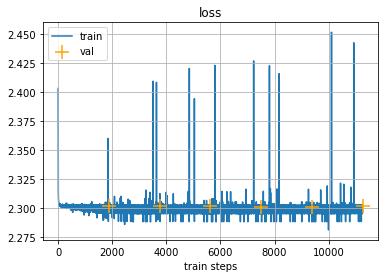

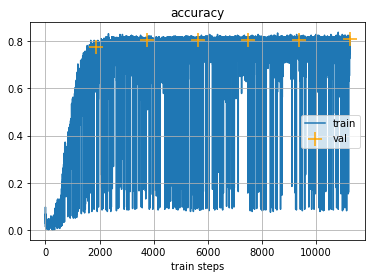

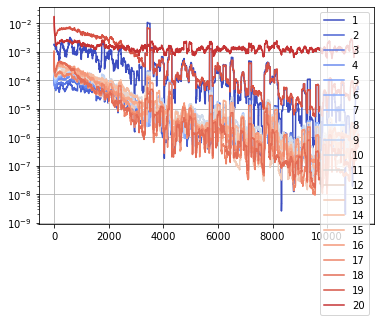

Epoch 6 of 10


100%|██████████| 312/312 [00:00<00:00, 317.53it/s]


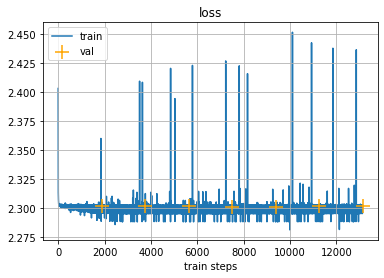

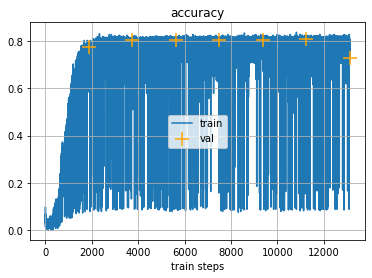

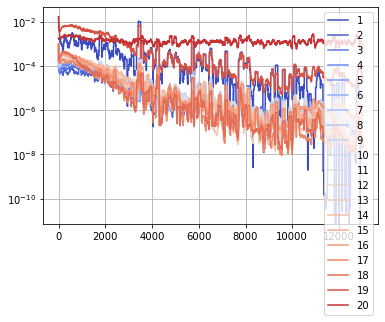

Epoch 7 of 10


100%|██████████| 312/312 [00:00<00:00, 446.44it/s]


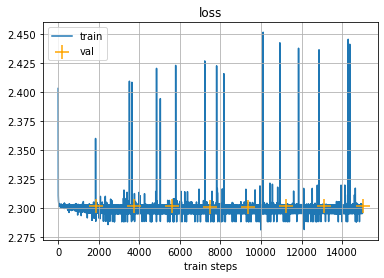

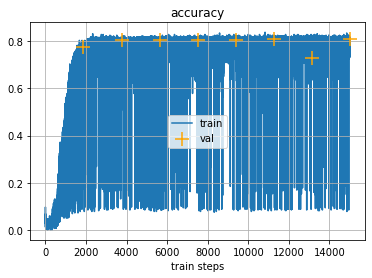

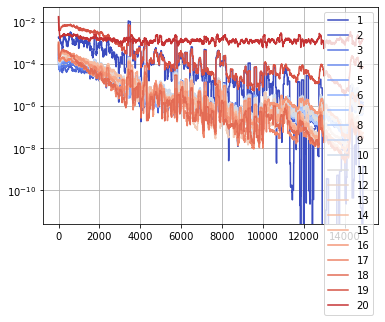

Epoch 8 of 10


100%|██████████| 312/312 [00:00<00:00, 435.87it/s]


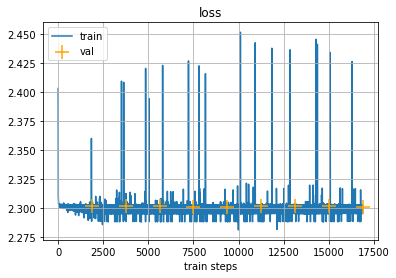

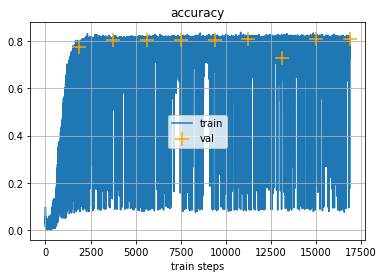

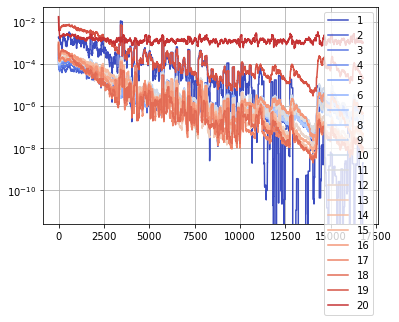

Epoch 9 of 10


100%|██████████| 312/312 [00:00<00:00, 482.31it/s]


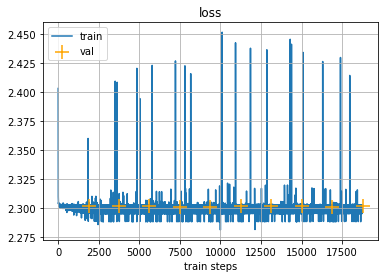

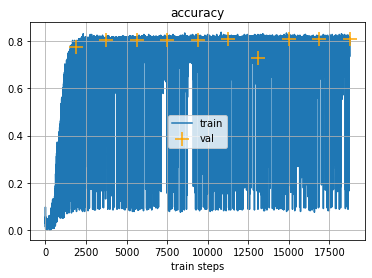

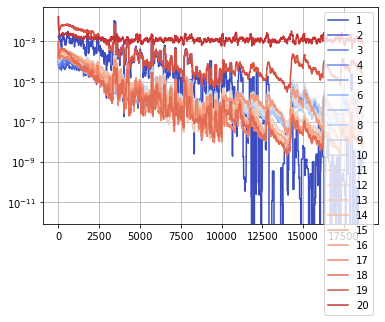

In [27]:
model = DeepDenseResNet(n_layers=20, hidden_size=10, activation=nn.Sigmoid())
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)

train_grad(model, opt, 10)